In [0]:
%reload_ext autoreload
%autoreload 2

In [0]:
from fastai.tabular import *

To create the feature-engineered train_clean and test_clean from the Kaggle competition data, run rossman_data_clean.ipynb.

In [0]:
path = Path('drive/My Drive')
train_df = pd.read_pickle(path/'train_clean')

In [6]:
train_df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
...,...,...,...,...,...
StateHoliday_bw,0,0,0,0,0
Promo_bw,5,5,5,5,5
SchoolHoliday_fw,7,1,5,1,1
StateHoliday_fw,0,0,0,0,0


In [7]:
n = len(train_df); n

844338

In [0]:
idx = np.random.permutation(range(n))[:2000]
idx.sort()
small_train_df = train_df.iloc[idx[:1000]]
small_test_df = train_df.iloc[idx[1000:]]
small_cont_vars = ['CompetitionDistance', 'Mean_Humidity']
small_cat_vars =  ['Store', 'DayOfWeek', 'PromoInterval']
small_train_df = small_train_df[small_cat_vars + small_cont_vars + ['Sales']]
small_test_df = small_test_df[small_cat_vars + small_cont_vars + ['Sales']]

In [9]:
small_train_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
183,184,5,NaN,3560.0,61,8190
379,381,5,"Feb,May,Aug,Nov",1800.0,55,10760
1662,551,4,NaN,2190.0,86,6429
2336,111,3,"Jan,Apr,Jul,Oct",7890.0,54,8068
2407,182,3,"Mar,Jun,Sept,Dec",1390.0,54,6256


In [10]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
410989,250,5,"Feb,May,Aug,Nov",3520.0,60,6727
411142,403,5,NaN,4970.0,71,6975
412311,457,4,"Jan,Apr,Jul,Oct",13140.0,80,3962
412873,1019,4,"Jan,Apr,Jul,Oct",2740.0,80,7235
412932,1078,4,"Jan,Apr,Jul,Oct",670.0,57,5184


In [0]:
categorify = Categorify(small_cat_vars, small_cont_vars)
categorify(small_train_df)
categorify(small_test_df, test=True)

In [12]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
410989,NaN,5,"Feb,May,Aug,Nov",3520.0,60,6727
411142,403,5,NaN,4970.0,71,6975
412311,NaN,4,"Jan,Apr,Jul,Oct",13140.0,80,3962
412873,1019,4,"Jan,Apr,Jul,Oct",2740.0,80,7235
412932,1078,4,"Jan,Apr,Jul,Oct",670.0,57,5184


In [13]:
small_train_df.PromoInterval.cat.categories

Index(['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec'], dtype='object')

In [14]:
small_train_df['PromoInterval'].cat.codes[:5]

183    -1
379     0
1662   -1
2336    1
2407    2
dtype: int8

In [0]:
fill_missing = FillMissing(small_cat_vars, small_cont_vars)
fill_missing(small_train_df)
fill_missing(small_test_df, test=True)

In [16]:
small_train_df[small_train_df['CompetitionDistance_na'] == True]

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales,CompetitionDistance_na
303590,291,5,NaN,2380.0,70,6942,True
330721,291,6,NaN,2380.0,84,5006,True
379043,879,1,"Feb,May,Aug,Nov",2380.0,74,4627,True


Preparing the dataset

In [0]:
train_df = pd.read_pickle(path/'train_clean')
test_df = pd.read_pickle(path/'test_clean')

In [18]:
len(train_df),len(test_df)

(844338, 41088)

In [0]:
procs=[FillMissing, Categorify, Normalize]

In [0]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [0]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()

In [22]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [23]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [24]:
valid_idx = range(cut)
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

In [0]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

**Model**

In [0]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [0]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

In [29]:
len(data.train_ds.cont_names)

16

epoch,train_loss,valid_loss,exp_rmspe,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


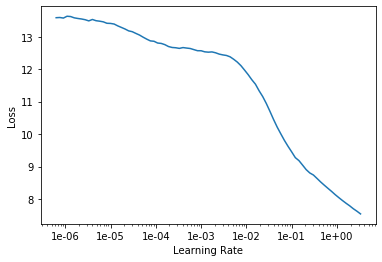

In [30]:
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(5, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.024825,0.032897,0.189294,02:50
1,0.020655,0.028240,0.149424,02:48
2,0.017655,0.028066,0.173960,02:47
3,0.011793,0.013020,0.109643,02:47
4,0.012845,0.011632,0.105091,02:47


In [0]:
learn.save('1')

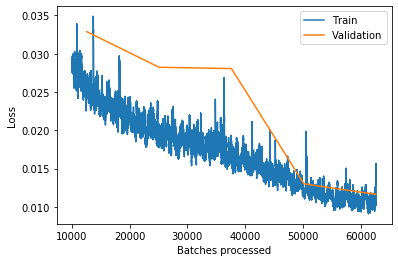

In [33]:
learn.recorder.plot_losses(skip_start=10000)

In [0]:
learn.load('1');

In [35]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.012682,0.012342,0.110025,02:46
1,0.011808,0.013773,0.119403,02:44
2,0.011077,0.015857,0.130694,02:45
3,0.010384,0.015323,0.118122,02:45
4,0.010712,0.014279,0.112886,02:50


In [36]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.010186,0.013971,0.118088,02:47
1,0.011471,0.017403,0.124327,02:50
2,0.010918,0.023089,0.133822,02:47
3,0.009529,0.018552,0.139530,02:47
4,0.009416,0.017971,0.125298,02:46


In [37]:
test_preds=learn.get_preds(DatasetType.Test)
test_df["Sales"]=np.exp(test_preds[0].data).numpy().T[0]
test_df[["Id","Sales"]]=test_df[["Id","Sales"]].astype("int")
test_df[["Id","Sales"]].to_csv("rossmann_submission.csv",index=False)